In [100]:
import matplotlib.pyplot as plt

def get_centered_limits(data_list, margin_ratio=0.1):
    flat_data = [value for sublist in data_list for value in sublist]
    data_mean = sum(flat_data) / len(flat_data)
    max_dev = max(abs(data_mean - min(flat_data)), abs(data_mean - max(flat_data)))
    max_dev *= (1 + margin_ratio)
    return (data_mean - max_dev, data_mean + max_dev)

def get_time(data):
    s = 0
    start_ms = data[0][1]
    ms_prev = 1000
    
    for i in range(len(data)):
        ms = data[i][1] - start_ms
        if ms < ms_prev:
            s += 1
        ms_prev = ms

    if ms < 0:
        s -= 1
        ms += 1000
    return s + ms / 1000.0

def plot(dataset):
    vicon_command = dataset[0]
    data = dataset[1:]
    
    total_time = get_time(data)
    num_points = len(data)
    time_values = [i * (total_time / num_points) for i in range(num_points)]



    column_labels = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']
    y_axis_labels = ['Position [m]', 'Angle [rad]']
    title_text = [' Position', ' Orientation']

    # Compute centered limits with margin
    position_limits = get_centered_limits([entry[2:5] for entry in data])
    orientation_limits = get_centered_limits([entry[5:8] for entry in data])

    # Create 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, label in enumerate(column_labels):
        component_data = [entry[i + 2] for entry in data]
        axes[i].plot(time_values, component_data, marker='o', linestyle='-', markersize=1, label=label)
        axes[i].set_title(label + title_text[i // 3], fontsize=14)
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(y_axis_labels[i // 3])
        axes[i].legend()
        axes[i].grid(True)

        if i < 3:  # X, Y, Z
            axes[i].set_ylim(position_limits)
        else:      # Roll, Pitch, Yaw
            axes[i].set_ylim(orientation_limits)

    # Add global title
    fig.suptitle(f"{vicon_command}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [101]:
mcap_path =  r"RosBags\PIDTEST0805V3\PIDTEST0805V3_0.mcap"
# ex. "RosBags/PIDTEST0805V4/PIDTEST0805V4_0.mcap"
# ex. r"RosBags\TurnOffTest0805\TurnOffTest0805_0.mcap"

In [102]:
from mcap_ros2.reader import read_ros2_messages
from pathlib import Path
import os

base_path = Path(os.getcwd()).parent
mcap_full_path = base_path / mcap_path

grouped_msgs = []
change_pos = []
i = 0

with open(mcap_full_path, "rb") as f:
    current_group = None
    for msg in read_ros2_messages(f):
        topic = msg.channel.topic
        
        if topic == "/rosout":
            if not grouped_msgs or msg.ros_msg.msg != (grouped_msgs[-1][0]):
                current_group = [msg.ros_msg.msg]
                grouped_msgs.append(current_group)
                
                if 'Starting goal position' in msg.ros_msg.msg:
                    change_pos.append(i)
                
                if 'Turning off the drone' in msg.ros_msg.msg:
                    change_pos.append(i)
                i += 1

        elif topic == "/Vicon" and current_group is not None:
            current_group.append(msg.ros_msg.data)


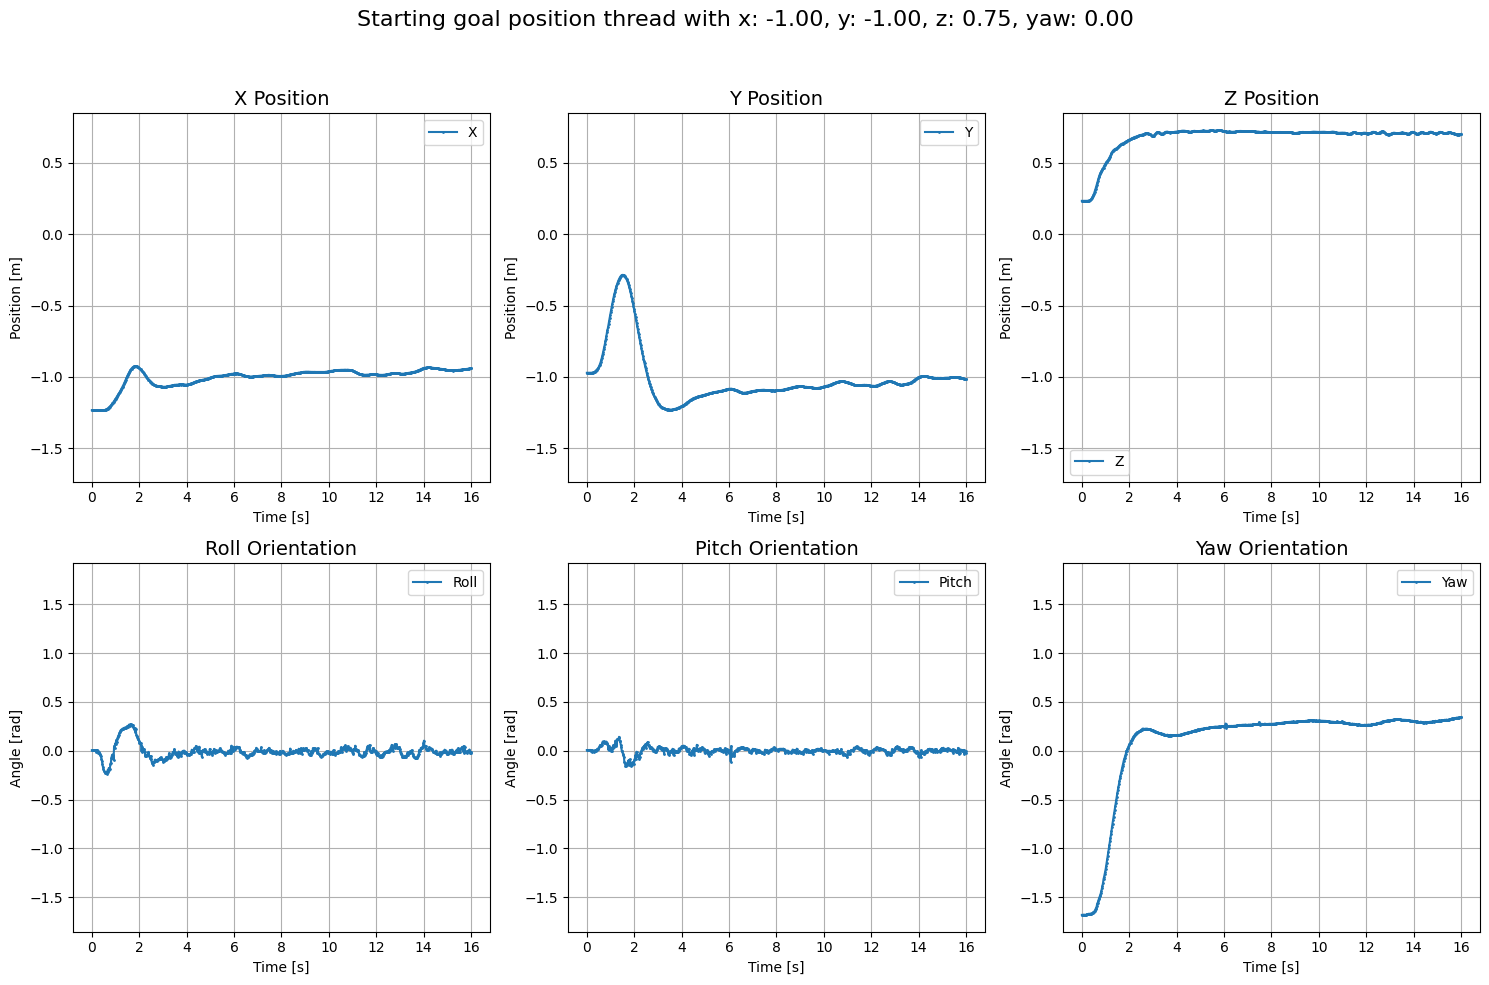

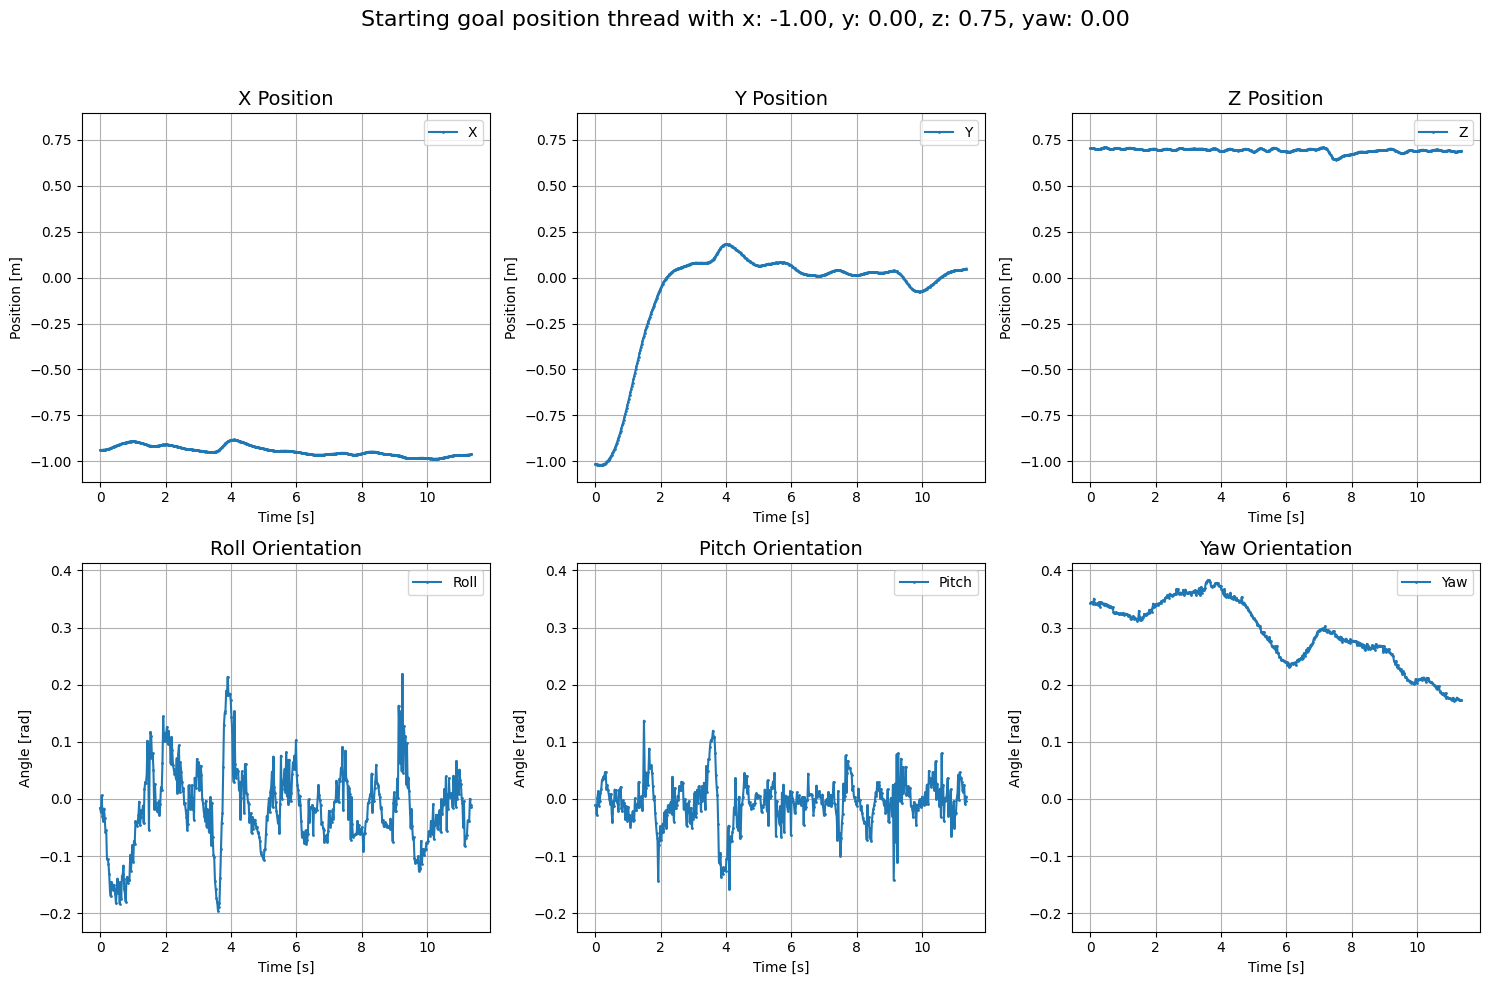

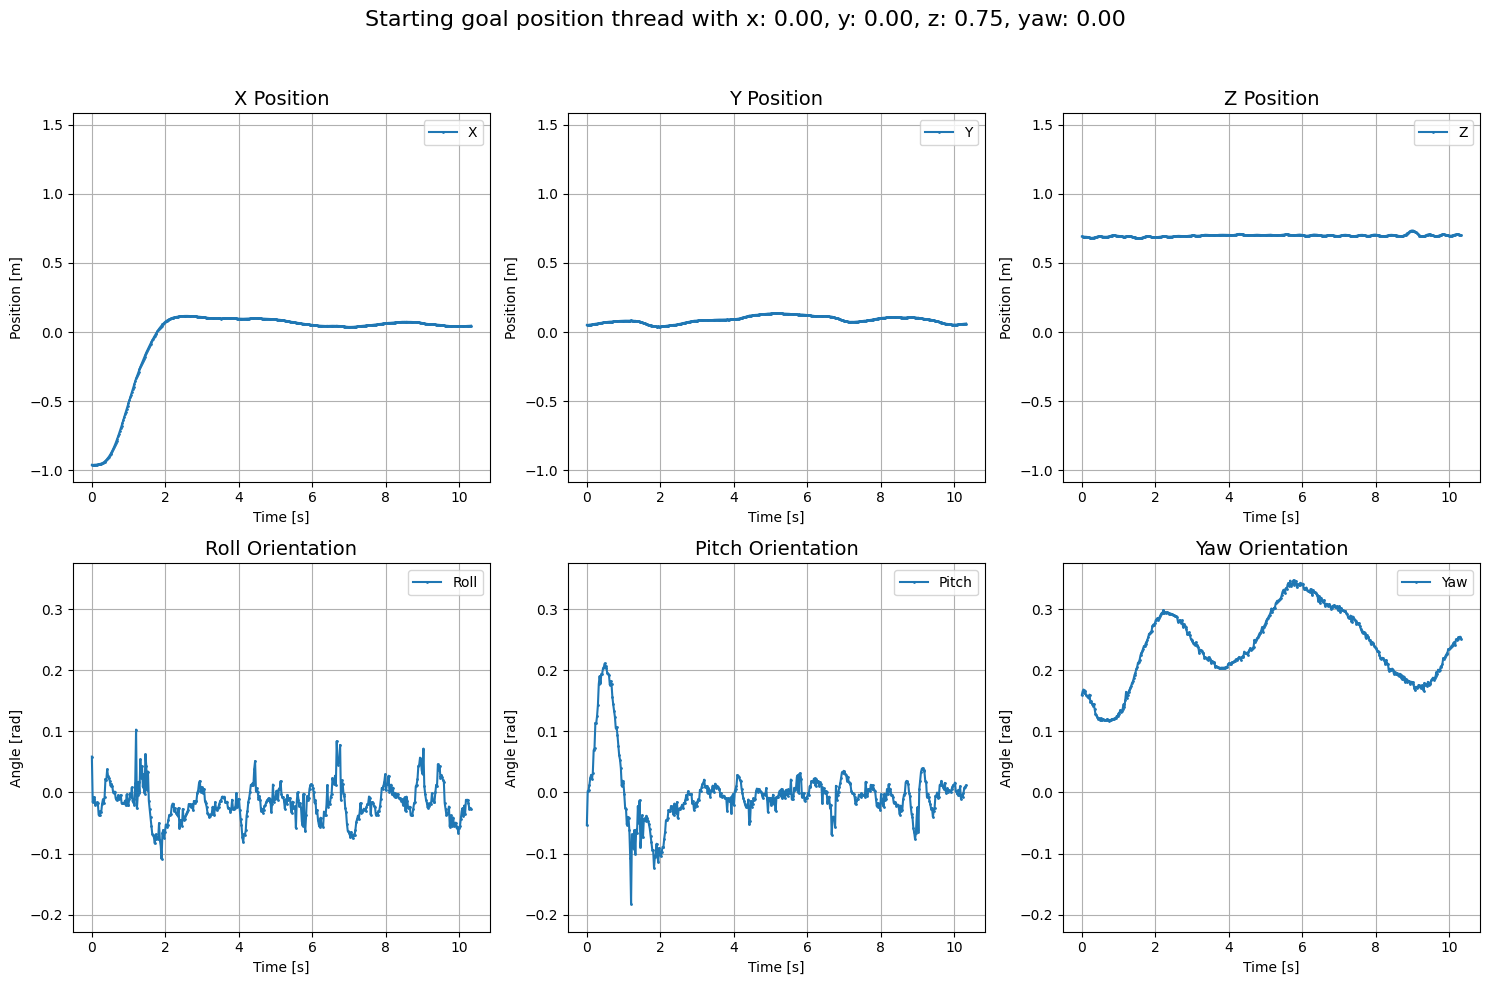

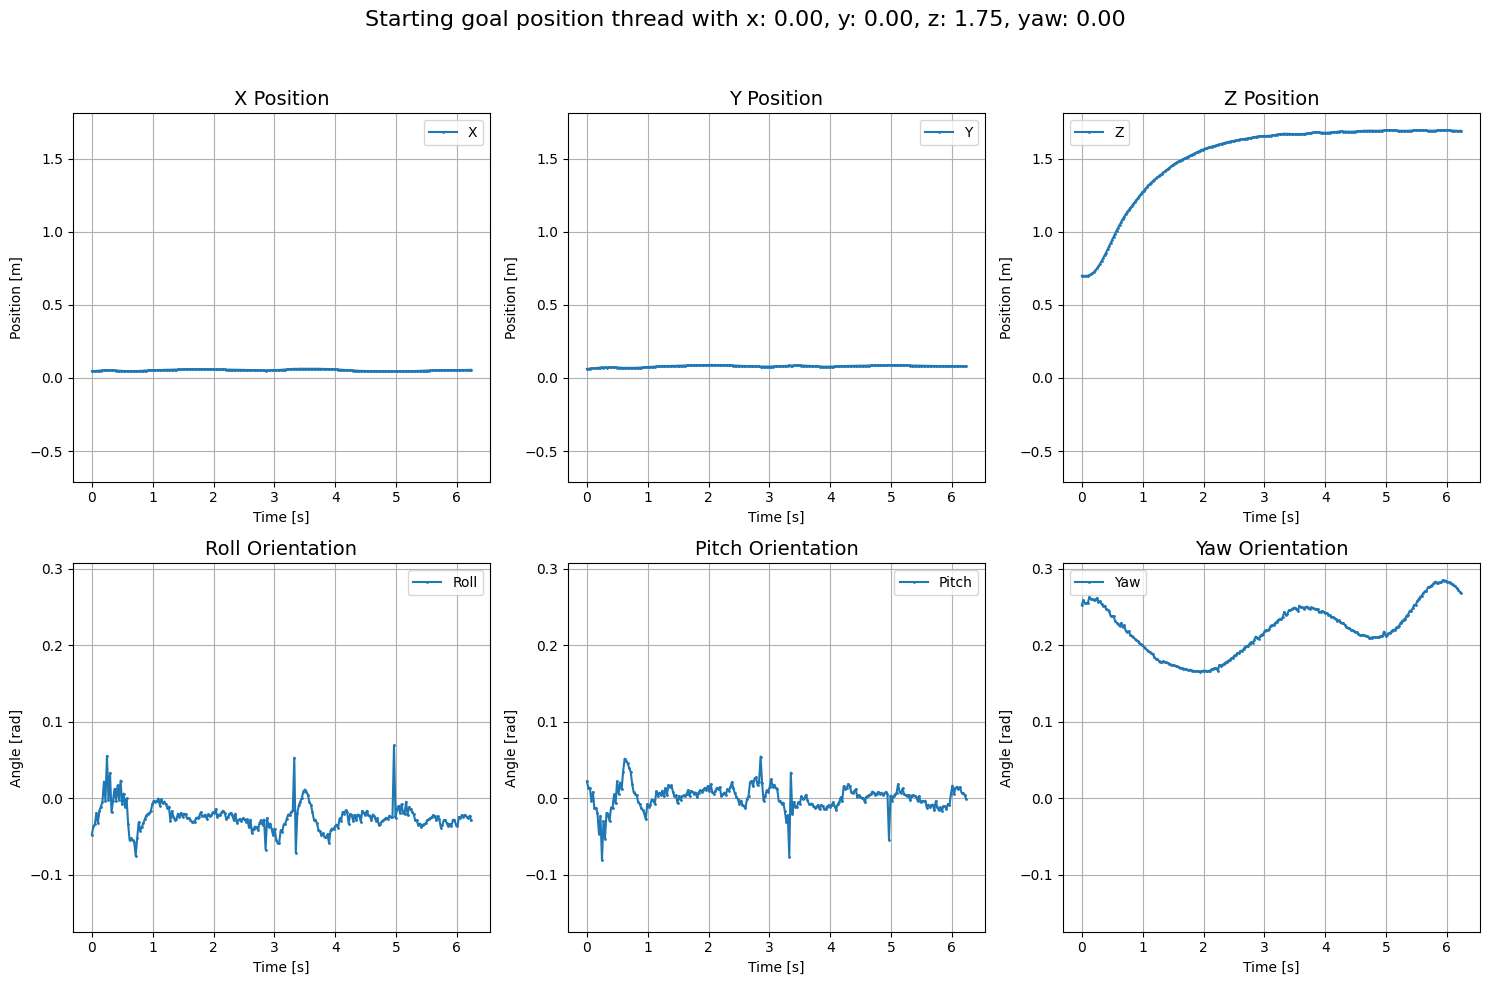

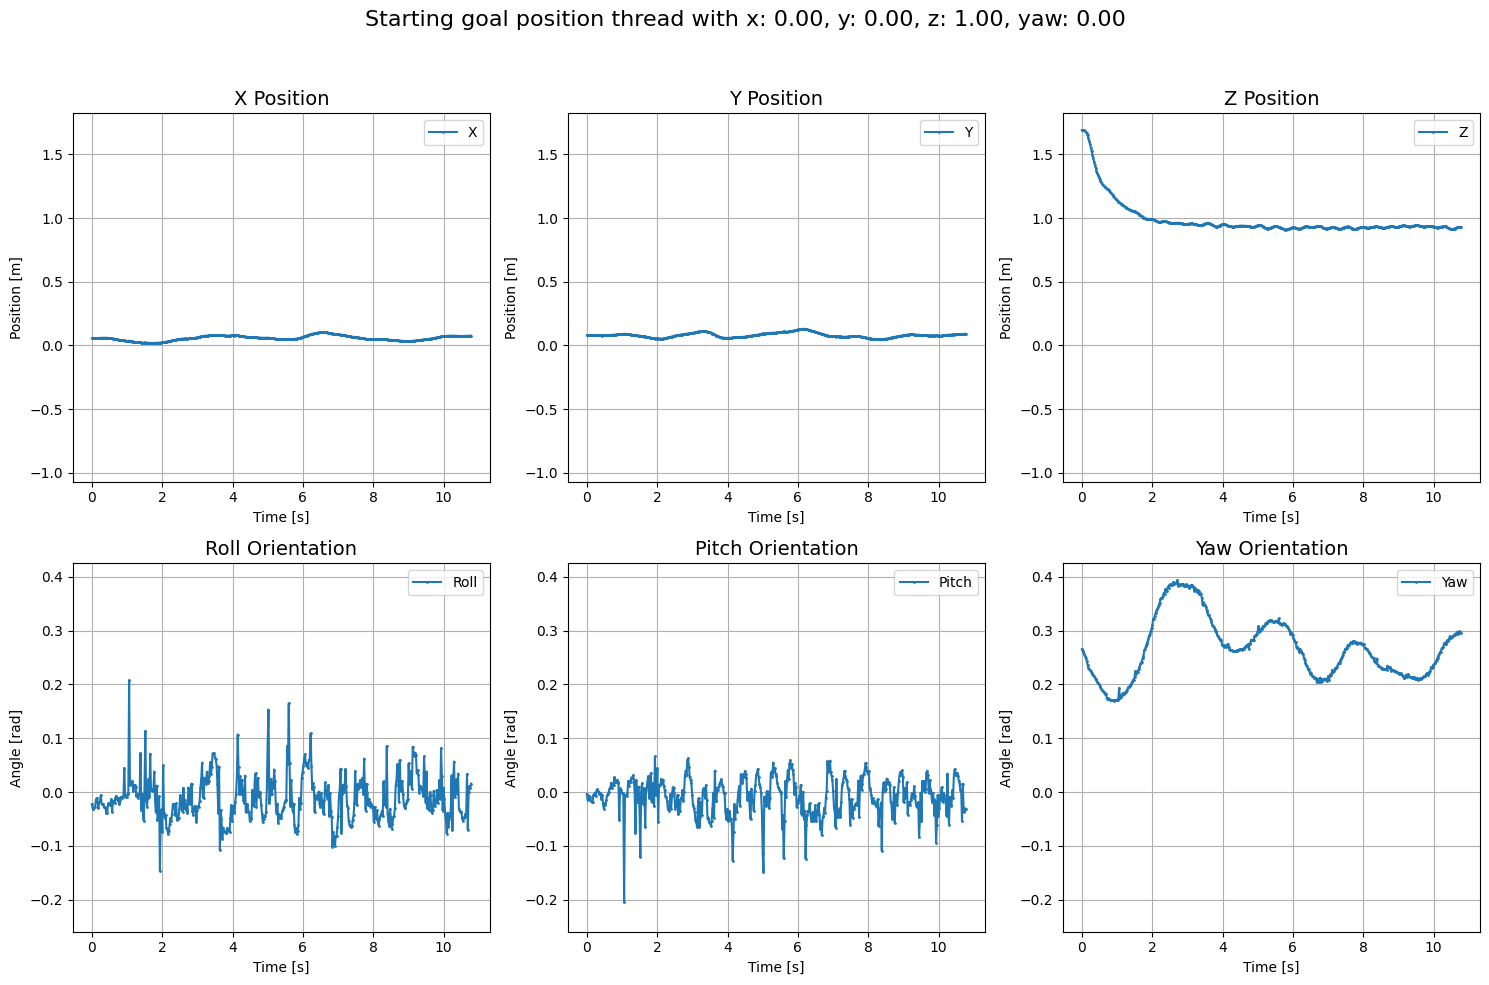

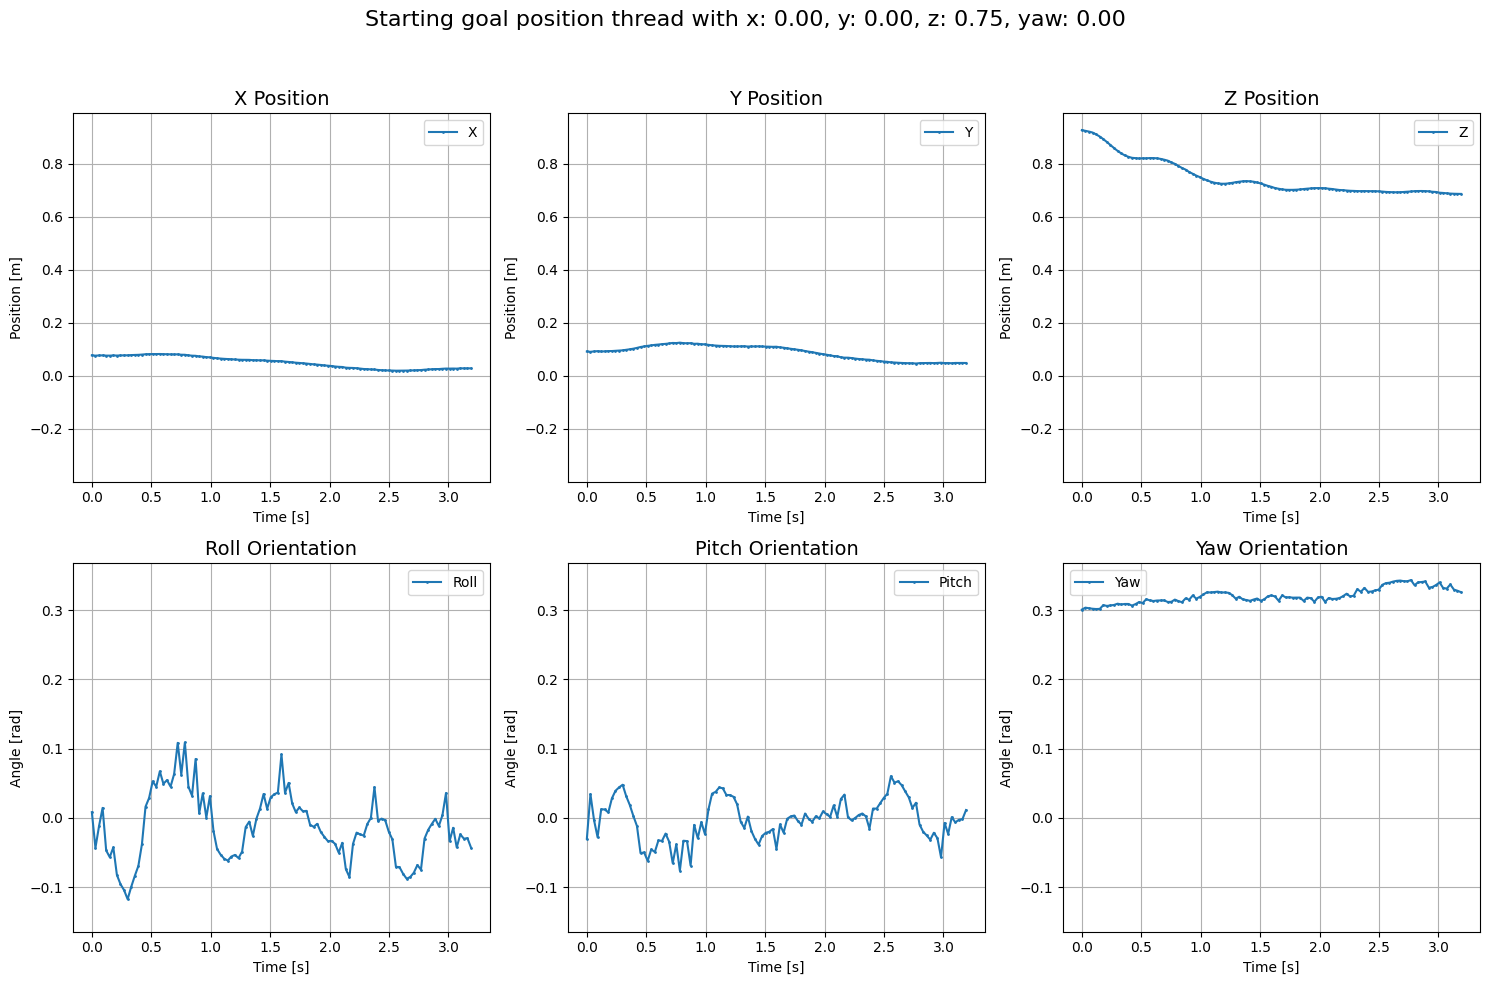

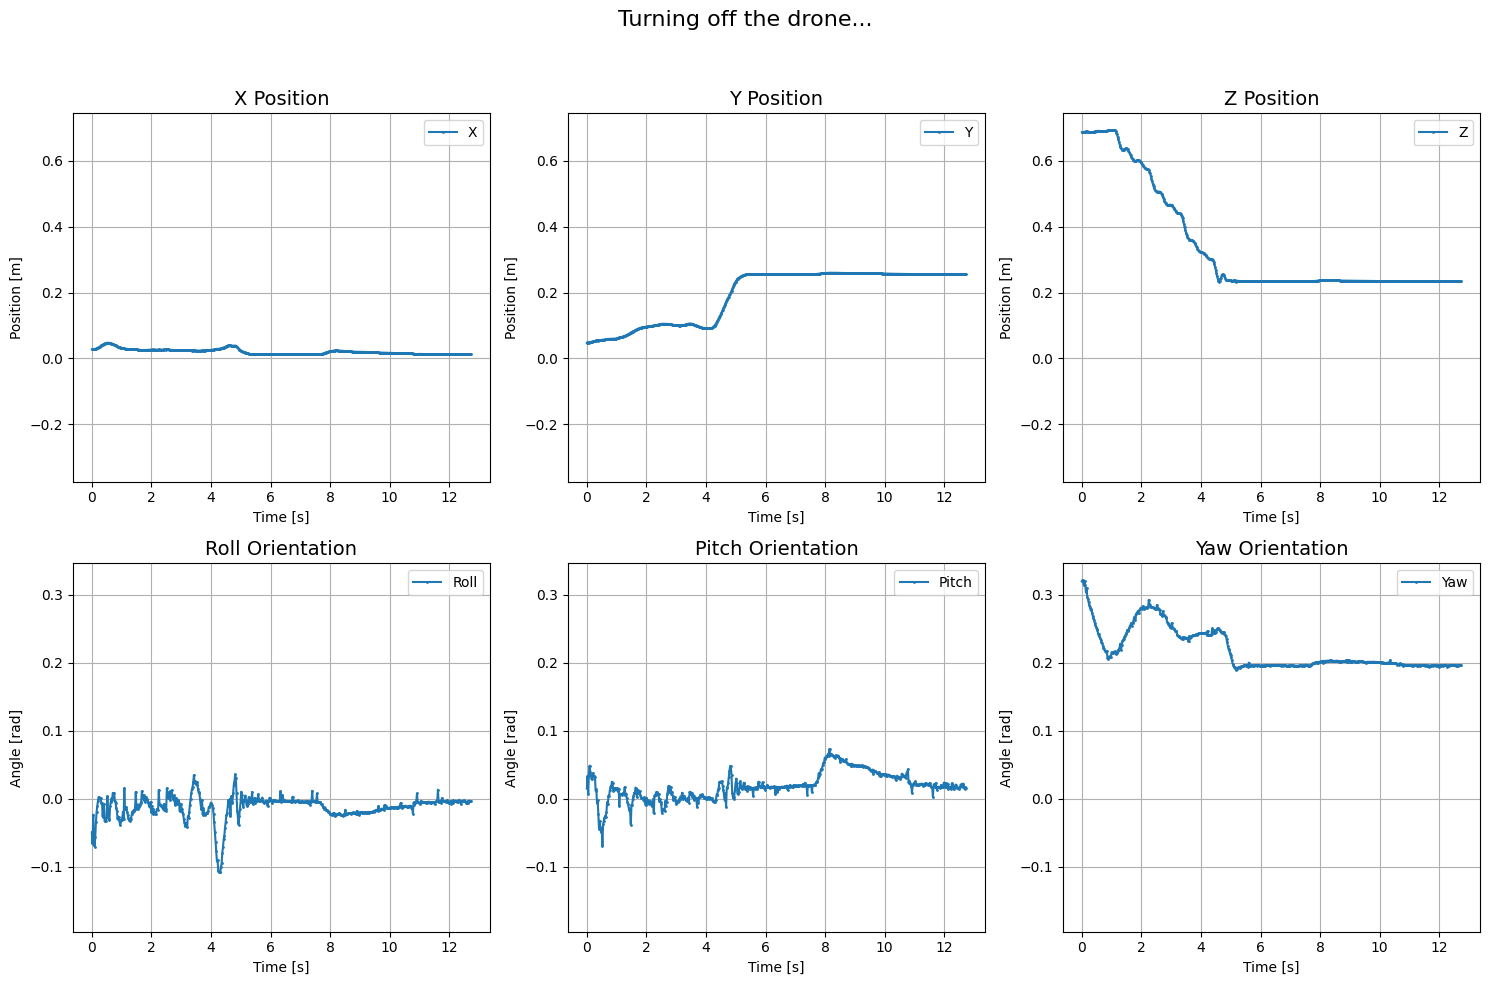

In [103]:
for data in change_pos:
    plot(grouped_msgs[data])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


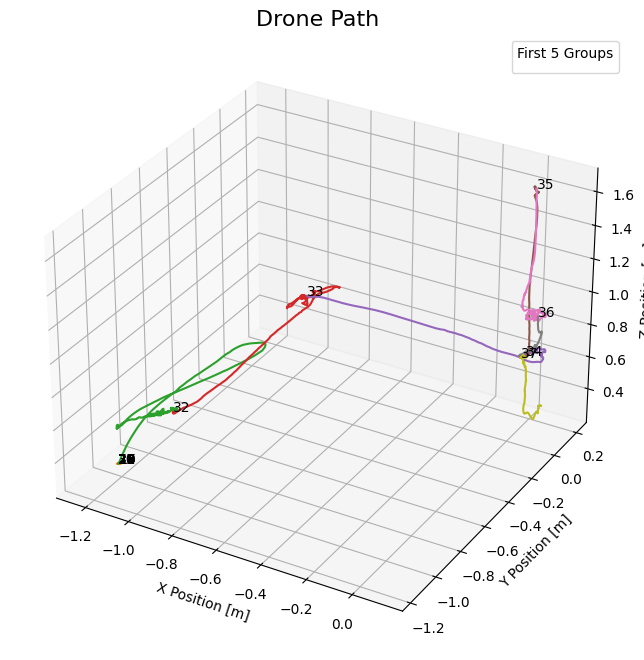

In [104]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3d_path(grouped_msgs):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')
    z_min, z_max = float('inf'), float('-inf')

    for idx, group in enumerate(grouped_msgs):
        if len(group) > 1 and isinstance(group[1], list):  # Ensure group contains valid data
            x = [entry[2] for entry in group[1:]]
            y = [entry[3] for entry in group[1:]]
            z = [entry[4] for entry in group[1:]]
            label = group[0] if idx < 5 else None  # Limit legend to first 5 groups
            ax.plot(x, y, z, label=label)

            # Add a number at the starting point of each segment
            ax.text(x[0], y[0], z[0], str(idx), fontsize=10, color='black')

            # Update global min and max for each axis
            x_min, x_max = min(x_min, min(x)), max(x_max, max(x))
            y_min, y_max = min(y_min, min(y)), max(y_max, max(y))
            z_min, z_max = min(z_min, min(z)), max(z_max, max(z))

    # Calculate the largest span
    max_span = max(x_max - x_min, y_max - y_min, z_max - z_min)

    # Set limits for each axis to ensure equal span
    x_mid = (x_max + x_min) / 2
    y_mid = (y_max + y_min) / 2
    z_mid = (z_max + z_min) / 2
    ax.set_xlim([x_mid - max_span / 2, x_mid + max_span / 2])
    ax.set_ylim([y_mid - max_span / 2, y_mid + max_span / 2])
    ax.set_zlim([z_mid - max_span / 2, z_mid + max_span / 2])

    ax.set_title("Drone Path", fontsize=16)
    ax.set_xlabel("X Position [m]")
    ax.set_ylabel("Y Position [m]")
    ax.set_zlabel("Z Position [m]")
    if len(grouped_msgs) > 5:
        ax.legend(title="First 5 Groups")
    else:
        ax.legend()
    plt.show()

plot_3d_path(grouped_msgs)

In [105]:
#csv file

import pandas as pd
from pathlib import Path
import os

base_path = Path(os.getcwd()).parent

test_turnoff_path = ["RosBags\\PIDV1.csv",
                     "RosBags\\PIDV2.csv",
                     "RosBags\\PIDV3.csv"]

test_turnoff = [[] for _ in range(len(test_turnoff_path))]
for i, test_path in enumerate(test_turnoff_path):
    test_path = base_path / test_path
    data = pd.read_csv(test_path)
    print(data.columns)

    for j in range(8):
        test_turnoff[i].append(data[f'/Vicon/data[{j}]'].dropna())


total_packages = len(test_turnoff[0][0])
time_s = get_time(test_turnoff[0])

package_s = time_s / total_packages


Index(['__time', '/Vicon/data[0]', '/Vicon/data[1]', '/Vicon/data[2]',
       '/Vicon/data[3]', '/Vicon/data[4]', '/Vicon/data[5]', '/Vicon/data[6]',
       '/Vicon/data[7]', '/Vicon/layout/data_offset',
       ...
       'DEaccz', 'Daccpitch', 'Daccroll', 'Daccyaw', 'QuatToPitchReal',
       'QuatToRoll', 'QuatToRollReal', 'QuatToYaw', 'QuatToYawReal',
       'Viconvx'],
      dtype='object', length=494)
Index(['__time', '/Vicon/data[0]', '/Vicon/data[1]', '/Vicon/data[2]',
       '/Vicon/data[3]', '/Vicon/data[4]', '/Vicon/data[5]', '/Vicon/data[6]',
       '/Vicon/data[7]', '/Vicon/layout/data_offset',
       ...
       'DEaccz', 'Daccpitch', 'Daccroll', 'Daccyaw', 'QuatToPitchReal',
       'QuatToRoll', 'QuatToRollReal', 'QuatToYaw', 'QuatToYawReal',
       'Viconvx'],
      dtype='object', length=494)
Index(['__time', '/Vicon/data[0]', '/Vicon/data[1]', '/Vicon/data[2]',
       '/Vicon/data[3]', '/Vicon/data[4]', '/Vicon/data[5]', '/Vicon/data[6]',
       '/Vicon/data[7]', '/Vicon

KeyError: 1